In [3]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=1117 sha256=96e188b75c33523f016d33d6ad3f854eebf5ecf888c8af395c95c986bb4ef48a
  Stored in directory: /tmp/pip-ephem-wheel-cache-eegt_bbp/wheels/77/22/bf/1fa8ed58576be030eee5dae5ac3492fdad354cd6536f6804a3
Successfully built rl4greencrab
  Attempting uninstall: rl4greencrab
    Found existing installation: rl4greencrab 1.0.0
    Uninstalling rl4greencrab-1.0.0:
      Successfully uninstalled rl4greencrab-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.green_crab_movingAvg import greenCrabMonthNormalizedMoving
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes, agent_action_plot
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from rl4greencrab import LipschitzPPO

## Monthly Environment Simulation

In [2]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':False,
    'variance_penalty_ratio': 0.3
    # "curriculum": True
}

In [36]:
def evaluateConstAct(x):
    config = {
        "w_mort_scale" : 600,
        "growth_k": 0.70,
        'random_start':True,
        'variance_penalty_ratio': 0.3
        # "curriculum": True
    }
    env = greenCrabMonthEnv(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [4]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-07-03 05:18:16,981	INFO worker.py:1917 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.4773
Function value obtained: 8.9341
Current minimum: 8.9341
Iteration No: 2 started. Evaluating function at random point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7589
Function value obtained: 29.0707
Current minimum: 8.9341
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6841
Function value obtained: 27.8249
Current minimum: 8.9341
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.7249
Function value obtained: 18.2864
Current minimum: 8.9341
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5904
Function value obtained: 22.8658
Current minimum: 8.9341
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.8297
Function value obtained: 36.8575
Current minimum: 8.9341
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluat

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 1.1783
Function value obtained: 20.8282
Current minimum: 8.9341
Iteration No: 12 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.9985
Function value obtained: 8.4323
Current minimum: 8.4323
Iteration No: 13 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.9418
Function value obtained: 8.6444
Current minimum: 8.4323
Iteration No: 14 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1.5343
Function value obtained: 8.2430
Current minimum: 8.2430
Iteration No: 15 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 2.0759
Function value obtained: 7.8393
Current minimum: 7.8393
Iteration No: 16 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.3137
Function value obtained: 7.6253
Current minimum: 7.6253
Iteration No: 17 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 1.7399
Function value obtained: 7.3803
Current minimum: 7.3803
Iteration No: 18 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.3864
Function value obtained: 7.0989
Current minimum: 7.0989
Iteration No: 19 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.1794
Function value obtained: 7.1138
Current minimum: 7.0989
Iteration No: 20 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.2248
Function value obtained: 7.2865
Current minimum: 7.0989
Iteration No: 21 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.4719
Function value obtained: 10.4011
Current minimum: 7.0989
Iteration No: 22 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.4336
Function value obtained: 7.2056
Current minimum: 7.0989
Iteration No: 23 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.2334
Function value obtained: 7.0860
Current minimum: 7.0860
Iteration No: 24 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.6163
Function value obtained: 6.9172
Current minimum: 6.9172
Iteration No: 25 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.4146
Function value obtained: 6.7567
Current minimum: 6.7567
Iteration No: 26 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.4050
Function value obtained: 6.6164
Current minimum: 6.6164
Iteration No: 27 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.5191
Function value obtained: 6.3732
Current minimum: 6.3732
Iteration No: 28 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.4296
Function value obtained: 6.7931
Current minimum: 6.3732
Iteration No: 29 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.1857
Function value obtained: 7.0063
Current minimum: 6.3732
Iteration No: 30 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 1.4180
Function value obtained: 9.5488
Current minimum: 6.3732
Iteration No: 31 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.3350
Function value obtained: 16.4725
Current minimum: 6.3732
Iteration No: 32 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.5174
Function value obtained: 11.7880
Current minimum: 6.3732
Iteration No: 33 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.7597
Function value obtained: 6.7542
Current minimum: 6.3732
Iteration No: 34 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 2.3964
Function value obtained: 6.4508
Current minimum: 6.3732
Iteration No: 35 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 2.0490
Function value obtained: 6.6174
Current minimum: 6.3732
Iteration No: 36 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.6477
Function value obtained: 6.6192
Current minimum: 6.3732
Iteration No: 37 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.7603
Function value obtained: 6.7646
Current minimum: 6.3732
Iteration No: 38 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.8087
Function value obtained: 6.6391
Current minimum: 6.3732
Iteration No: 39 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.9693
Function value obtained: 6.6437
Current minimum: 6.3732
Iteration No: 40 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.7945
Function value obtained: 6.5975
Current minimum: 6.3732
Iteration No: 41 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.0641
Function value obtained: 6.3284
Current minimum: 6.3284
Iteration No: 42 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.3617
Function value obtained: 6.1017
Current minimum: 6.1017
Iteration No: 43 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.8438
Function value obtained: 6.5696
Current minimum: 6.1017
Iteration No: 44 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.3868
Function value obtained: 9.3757
Current minimum: 6.1017
Iteration No: 45 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.9264
Function value obtained: 6.4745
Current minimum: 6.1017
Iteration No: 46 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 2.4411
Function value obtained: 6.2168
Current minimum: 6.1017
Iteration No: 47 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 2.8568
Function value obtained: 6.3314
Current minimum: 6.1017
Iteration No: 48 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 2.5595
Function value obtained: 11.8083
Current minimum: 6.1017
Iteration No: 49 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 2.3165
Function value obtained: 6.4311
Current minimum: 6.1017
Iteration No: 50 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 2.1952
Function value obtained: 6.1815
Current minimum: 6.1017
Iteration No: 51 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 2.3029
Function value obtained: 6.6678
Current minimum: 6.1017
Iteration No: 52 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 2.8162
Function value obtained: 6.3469
Current minimum: 6.1017
Iteration No: 53 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 3.8586
Function value obtained: 6.6234
Current minimum: 6.1017
Iteration No: 54 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 3.0934
Function value obtained: 6.3130
Current minimum: 6.1017
Iteration No: 55 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 2.9453
Function value obtained: 6.8935
Current minimum: 6.1017
Iteration No: 56 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 2.1987
Function value obtained: 8.3681
Current minimum: 6.1017
Iteration No: 57 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 2.6743
Function value obtained: 7.7711
Current minimum: 6.1017
Iteration No: 58 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 2.4699
Function value obtained: 6.5551
Current minimum: 6.1017
Iteration No: 59 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 2.7474
Function value obtained: 6.2418
Current minimum: 6.1017
Iteration No: 60 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 2.7377
Function value obtained: 7.6019
Current minimum: 6.1017
Iteration No: 61 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 2.9389
Function value obtained: 6.5068
Current minimum: 6.1017
Iteration No: 62 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 3.0976
Function value obtained: 6.2810
Current minimum: 6.1017
Iteration No: 63 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 2.5161
Function value obtained: 6.3190
Current minimum: 6.1017
Iteration No: 64 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 2.9595
Function value obtained: 6.2234
Current minimum: 6.1017
Iteration No: 65 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 3.2013
Function value obtained: 6.2682
Current minimum: 6.1017
Iteration No: 66 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 3.4336
Function value obtained: 6.2261
Current minimum: 6.1017
Iteration No: 67 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 3.3524
Function value obtained: 6.3985
Current minimum: 6.1017
Iteration No: 68 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 3.1682
Function value obtained: 6.2003
Current minimum: 6.1017
Iteration No: 69 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 3.0050
Function value obtained: 6.2902
Current minimum: 6.1017
Iteration No: 70 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 4.0095
Function value obtained: 6.4280
Current minimum: 6.1017
Iteration No: 71 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 3.3266
Function value obtained: 6.3672
Current minimum: 6.1017
Iteration No: 72 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 3.2897
Function value obtained: 6.2430
Current minimum: 6.1017
Iteration No: 73 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 4.3501
Function value obtained: 6.8178
Current minimum: 6.1017
Iteration No: 74 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 3.2315
Function value obtained: 6.2831
Current minimum: 6.1017
Iteration No: 75 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 3.6931
Function value obtained: 6.2274
Current minimum: 6.1017
Iteration No: 76 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 5.4643
Function value obtained: 6.3244
Current minimum: 6.1017
Iteration No: 77 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 3.5697
Function value obtained: 6.3896
Current minimum: 6.1017
Iteration No: 78 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 3.5910
Function value obtained: 6.2407
Current minimum: 6.1017
Iteration No: 79 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 4.3146
Function value obtained: 6.4267
Current minimum: 6.1017
Iteration No: 80 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 3.5205
Function value obtained: 6.3754
Current minimum: 6.1017
Iteration No: 81 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 3.5704
Function value obtained: 6.2178
Current minimum: 6.1017
Iteration No: 82 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 4.6792
Function value obtained: 6.4156
Current minimum: 6.1017
Iteration No: 83 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 4.6128
Function value obtained: 6.3164
Current minimum: 6.1017
Iteration No: 84 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3.7910
Function value obtained: 6.2653
Current minimum: 6.1017
Iteration No: 85 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 4.1024
Function value obtained: 6.2580
Current minimum: 6.1017
Iteration No: 86 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 4.8925
Function value obtained: 6.3018
Current minimum: 6.1017
Iteration No: 87 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 8.2197
Function value obtained: 6.1861
Current minimum: 6.1017
Iteration No: 88 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 6.6129
Function value obtained: 6.2010
Current minimum: 6.1017
Iteration No: 89 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 5.0424
Function value obtained: 6.3912
Current minimum: 6.1017
Iteration No: 90 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 3.9438
Function value obtained: 6.1720
Current minimum: 6.1017
Iteration No: 91 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 4.4016
Function value obtained: 6.3127
Current minimum: 6.1017
Iteration No: 92 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 4.2040
Function value obtained: 6.3736
Current minimum: 6.1017
Iteration No: 93 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 4.3757
Function value obtained: 6.1606
Current minimum: 6.1017
Iteration No: 94 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 4.2093
Function value obtained: 6.2455
Current minimum: 6.1017
Iteration No: 95 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 4.8539
Function value obtained: 6.4237
Current minimum: 6.1017
Iteration No: 96 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 4.8094
Function value obtained: 6.4107
Current minimum: 6.1017
Iteration No: 97 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 5.2463
Function value obtained: 6.5681
Current minimum: 6.1017
Iteration No: 98 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 5.4022
Function value obtained: 6.3988
Current minimum: 6.1017
Iteration No: 99 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 3.4406
Function value obtained: 6.3265
Current minimum: 6.1017
Iteration No: 100 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 9.3398
Function value obtained: 6.2551
Current minimum: 6.1017
CPU times: user 2h 49min 31s, sys: 16.8 s, total: 2h 49min 48s
Wall time: 4min 48s


[409.28125108432624, 777.3743886426705, 0.0]

In [5]:
evaluateConstAct(
    [409.28125108432624, 777.3743886426705, 0.0]
)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


6.204009231442992

In [37]:
# with nonNormalized env
evaluateConstAct(
    [0.0, 0.0, 154.3889141214999]
)

5.15207245863105

In [38]:
import ray
ray.shutdown()

In [8]:
env = greenCrabMonthEnv(config)
agent = multiConstAction(env=env, action=np.array([409.28125108432624, 777.3743886426705, 0.0]))
constantData = simulator(env = env, agent = agent).simulate_full_named_dict_obs_acts()
constantDataDF = pd.DataFrame(constantData)

<Axes: xlabel='t'>

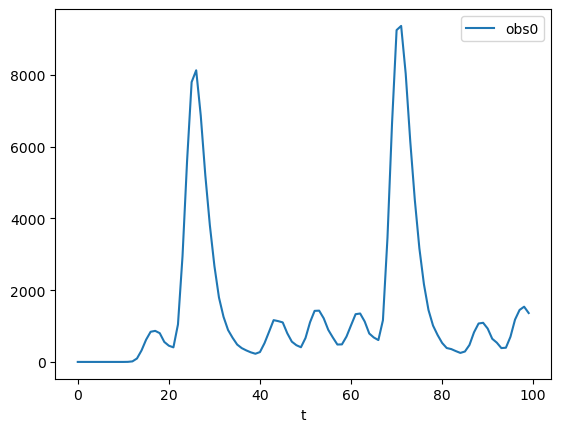

In [9]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

### normalized environment

In [10]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    # "curriculum": True
}

In [11]:
env = greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [12]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    rewards = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200, return_episode_rewards=True)
    m_reward = np.mean(rewards)
    return -m_reward, rewards

In [13]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [14]:
norm_act = normalized_action([409.28125108432624, 777.3743886426705, 0.0], 3000)
m_reward, const_rews = evaluateConstAct(norm_act)
np.mean(const_rews)

2025-07-03 05:24:14,429	INFO worker.py:1917 -- Started a local Ray instance.


-6.506790052245296

In [15]:
import ray
ray.shutdown()

In [16]:
agent = multiConstAction(env=env, action=np.array(norm_act))

In [17]:
constantData = simulator(env = env, agent = agent).simulate_full_named_dict_obs_acts()
constantDataDF = pd.DataFrame(constantData)

<Axes: xlabel='t'>

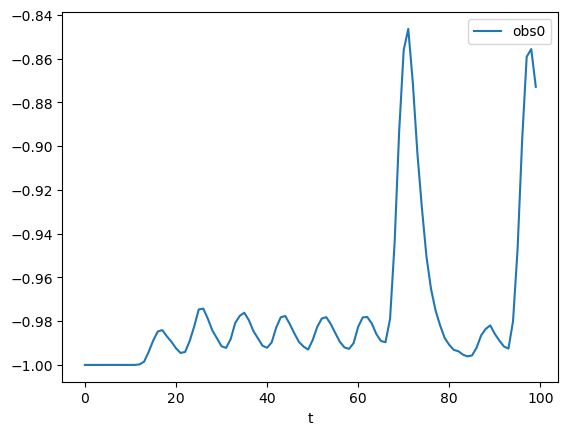

In [18]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained models

In [52]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

In [3]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}

In [4]:
evalEnv =  greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [5]:
path = "../saved_agents"
path = "varianceRatio1/"
td3Agent = TD3.load(f"varianceRatio0.3/TD3_gcmenorm", device="cpu")
ppoAgent = PPO.load(f"varianceRatio0.3/PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load(f"varianceRatio0.3/TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("varianceRatio0.3/RecurrentPPO_gcmenorm_256_1_varR0.3", device="cpu")
lppoAgent = LipschitzPPO.load("varianceRatio0.3/LipschitzPPO_gcmenorm_0.1_1", device="cpu")

In [8]:
import ray
N_EPS = 30
ray.init()
ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
lppo_rew = evaluate_agent(agent=lppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-07-16 00:12:53,468	INFO worker.py:1917 -- Started a local Ray instance.


False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'memory': 21088614400.0, 'node:__internal_head__': 1.0, 'object_store_memory': 9037977600.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'node:__internal_head__': 1.0, 'memory': 21088614400.0, 'object_store_memory': 9037977600.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'object_store_memory': 9037977600.0, 'node:__internal_head__': 1.0, 'memory': 21088614400.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'memory': 21088614400.0, 'object_store_memory': 9037977600.0, 'node:__internal_head__': 1.0}
False
{'node:10.42.0.115': 1.0, 'CPU': 128.0, 'object_store_memory': 9037977600.0, 'memory': 21088614400.0, 'node:__internal_head__': 1.0}


In [9]:
import ray
ray.shutdown()

In [10]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
LipschitzPPO mean rew = {lppo_rew}
""")


PPO mean rew = -5.627526346528197
TQC mean rew = -5.943618422780825
TD3 mean rew = -5.6461251459487585
RecurrentPPO mean rew = -4.991103079231134
LipschitzPPO mean rew = -7.288385949191403



### RL action plots

In [11]:
evalEnv =  greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


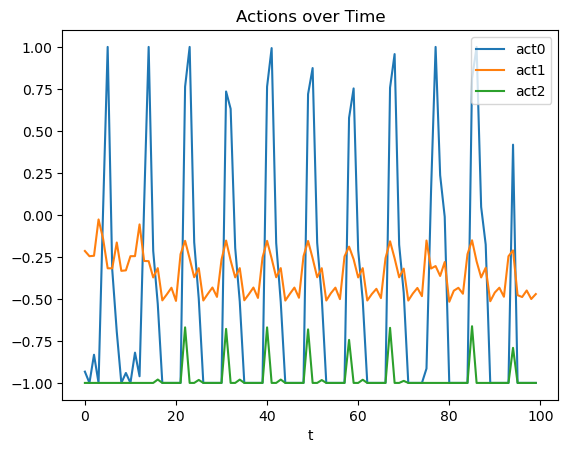

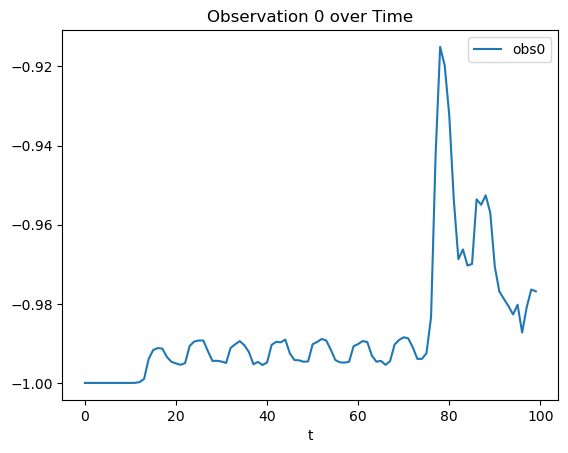

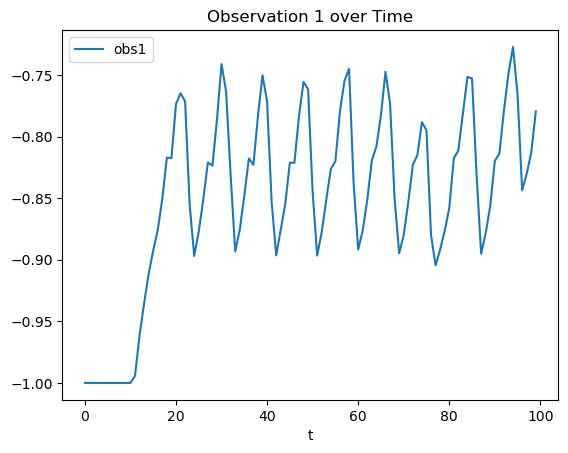

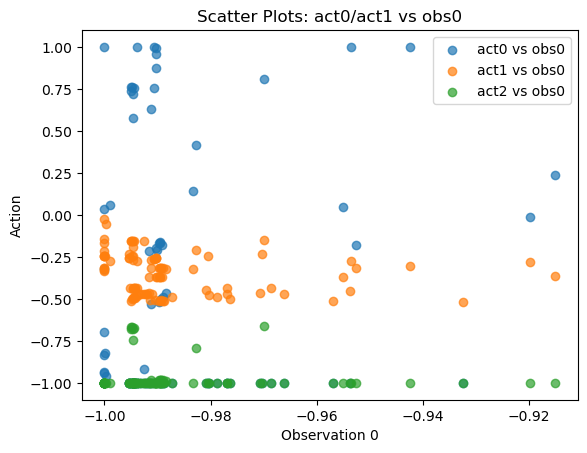

In [12]:
recurrentppoDataDF = agent_action_plot(evalEnv=evalEnv, agent=recurrentPPOAgent)

<Axes: title={'center': 'Actions over Time'}, xlabel='t'>

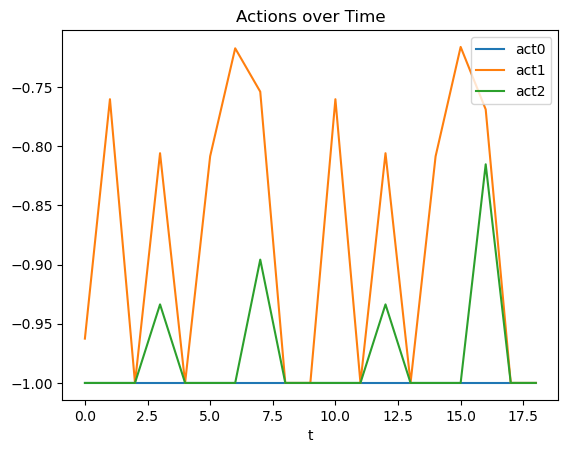

In [86]:
recurrentppoDataDF[recurrentppoDataDF.rep == 0].head(19).plot(x='t', y=['act0', 'act1', 'act2'], title="Actions over Time")

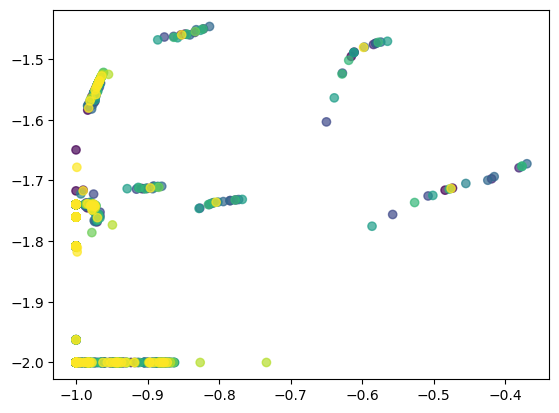

In [87]:
df = recurrentppoDataDF
fig, ax = plt.subplots()
ax.scatter(x=df['obs0'], y=df['act2'] + df['act1'], label='act2 vs obs1', alpha=0.7, c=df.rep)
# ax.scatter(x=df[df.rep == 0]['act1'], y=df[df.rep == 0]['act2'], label='act2 vs act1', alpha=0.7)

In [42]:
ppoAgent = PPO.load(f"PPO_gcmenorm_0", device="cpu")

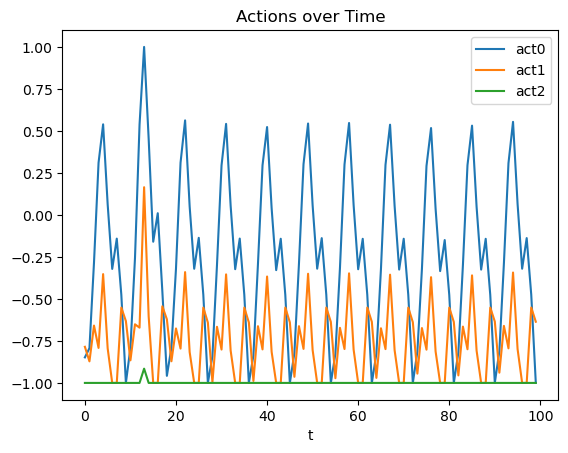

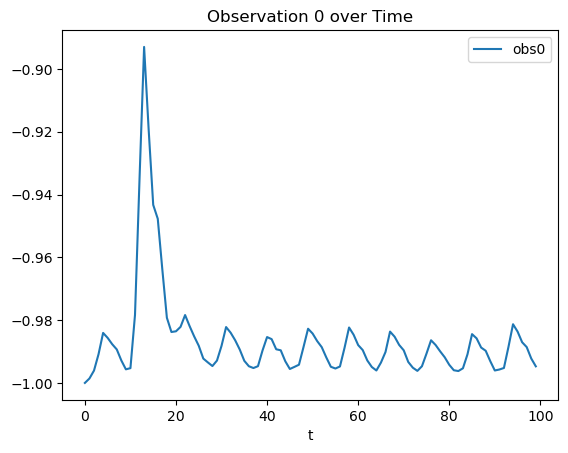

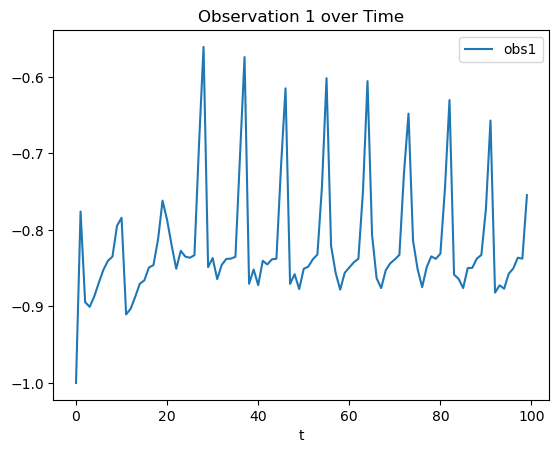

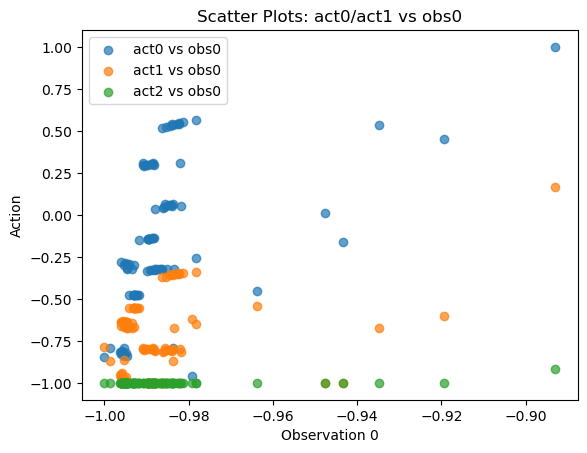

In [43]:
ppoDataDF = agent_action_plot(evalEnv=evalEnv, agent=ppoAgent)

<Axes: xlabel='t'>

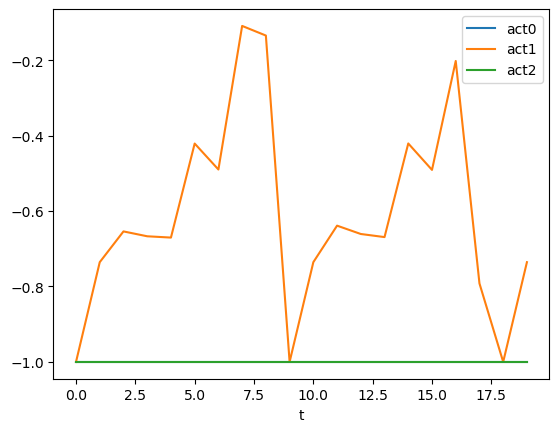

In [179]:
ppoDataDF[ppoDataDF.rep == 0].head(20).plot(x='t', y =['act0', 'act1', 'act2'])